In [4]:
# -*- coding: utf-8 -*-

# 01-BU

"""

Describe the business objectives here

"""

# 02-DU

# Load Dataset

file = 'WA_Fn-UseC_-Telco-Customer-Churn.xlsx'

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a Spark session
spark = SparkSession.builder \
    .appName("ExcelFileReader") \
    .config("spark.jars.packages", "com.crealytics:spark-excel_2.12:0.13.5") \
    .getOrCreate()
# Read the Excel file
df = spark.read \
    .format("com.crealytics.spark.excel") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(file)
df.show()
# Get the shape of the DataFrame
num_rows = df.count()
num_cols = len(df.columns)
print((num_rows, num_cols))
df.printSchema()
# Convert columns to numeric
df = df.withColumn("MonthlyCharges", col("MonthlyCharges").cast("double"))
df = df.withColumn("TotalCharges", col("TotalCharges").cast("double"))

+----------+------+-------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|ZipCode|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female| 4584.0|          

+----------+------+-------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|ZipCode|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female| 4584.0|          

In [6]:
import pandas as pd
# Convert to pandas DataFrame for better display
pandas_df = df.toPandas()

# Display the pandas DataFrame
display(pandas_df)
pandas_df.info()

,customerID,gender,ZipCode,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,4584.0,0.0,Yes,No,1.0,No,No phone service,DSL,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,6485.0,0.0,No,No,34.0,Yes,No,DSL,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,5423.0,0.0,No,No,2.0,Yes,No,DSL,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,9023.0,0.0,No,No,45.0,No,No phone service,DSL,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,2490.0,0.0,No,No,2.0,Yes,No,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,3549.0,0.0,Yes,Yes,24.0,Yes,Yes,DSL,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,6260.0,0.0,Yes,Yes,72.0,Yes,Yes,Fiber optic,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,6333.0,0.0,Yes,Yes,11.0,No,No phone service,DSL,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,4739.0,1.0,Yes,No,4.0,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   ZipCode           3618 non-null   float64
 3   SeniorCitizen     7043 non-null   float64
 4   Partner           7043 non-null   object 
 5   Dependents        7043 non-null   object 
 6   tenure            7043 non-null   float64
 7   PhoneService      7043 non-null   object 
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7041 non-null   object 
 13  TechSupport       7041 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 


+-------+---------------+
|summary|InternetService|
+-------+---------------+
|  count|           7043|
|   mean|           null|
| stddev|           null|
|    min|            DSL|
|    max|             No|
+-------+---------------+

[Row(InternetService='Fiber optic', count=3096), Row(InternetService='No', count=1526), Row(InternetService='DSL', count=2419), Row(InternetService='DSLdsf', count=1), Row(InternetService='DSLdsaf', count=1)]


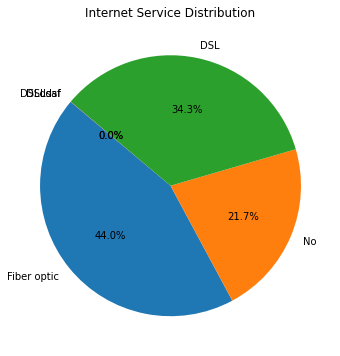

In [12]:
# Explore Data
import matplotlib.pyplot as plt

# Describe the 'InternetService' column
df.select("InternetService").describe().show()

# Get the value counts for 'InternetService'
internet_service_counts = df.groupBy("InternetService").count()
internet_service_counts_df = internet_service_counts.collect()
print(internet_service_counts_df)

# Extract data for plotting
internet_service_labels = [row['InternetService'] for row in internet_service_counts_df]
internet_service_values = [row['count'] for row in internet_service_counts_df]

# Plot the Internet Service Distribution
plt.figure(figsize=(8, 6))
plt.pie(internet_service_values, labels=internet_service_labels, autopct='%1.1f%%', startangle=140)
plt.title('Internet Service Distribution')
plt.show()

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


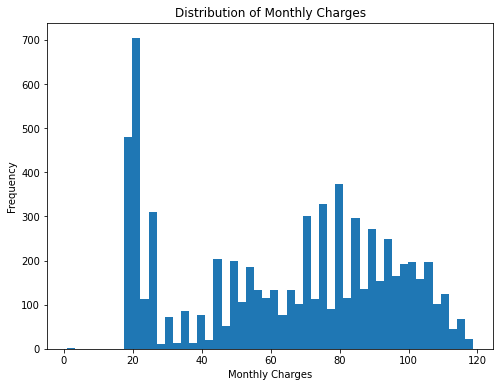

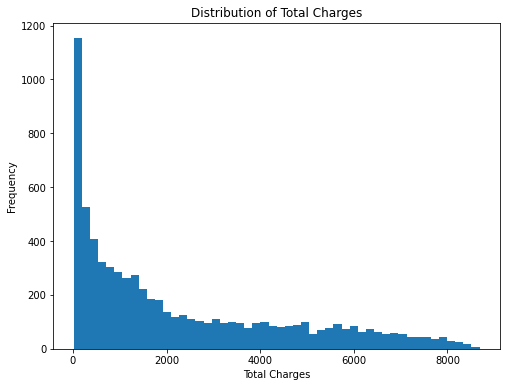

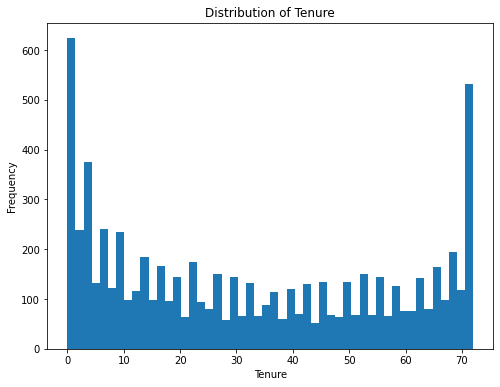

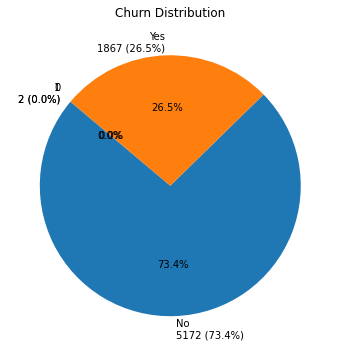

Null Counts:
+------------------+--------------+
| Column           |   Null Count |
+==================+==============+
| customerID       |            0 |
+------------------+--------------+
| gender           |            0 |
+------------------+--------------+
| ZipCode          |         3425 |
+------------------+--------------+
| SeniorCitizen    |            0 |
+------------------+--------------+
| Partner          |            0 |
+------------------+--------------+
| Dependents       |            0 |
+------------------+--------------+
| tenure           |            0 |
+------------------+--------------+
| PhoneService     |            0 |
+------------------+--------------+
| MultipleLines    |            0 |
+------------------+--------------+
| InternetService  |            0 |
+------------------+--------------+
| OnlineSecurity   |            0 |
+------------------+--------------+
| OnlineBackup     |            0 |
+------------------+--------------+
| DeviceProtect

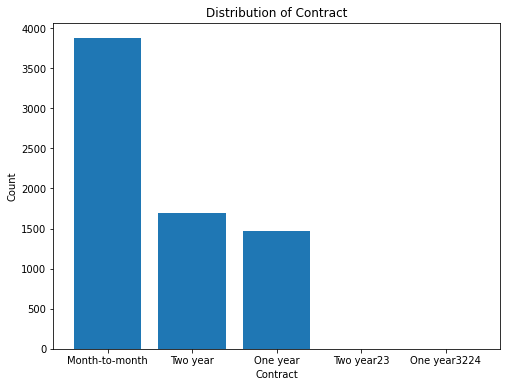

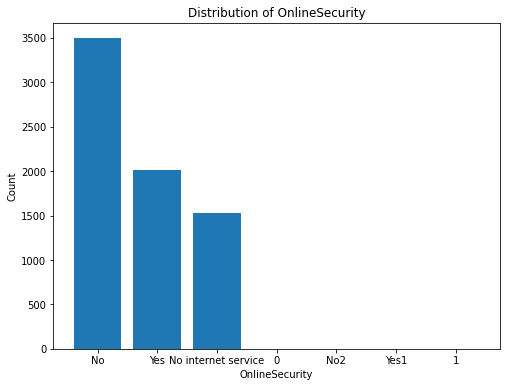

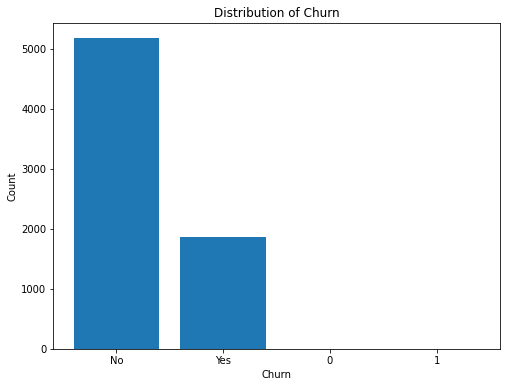

In [23]:
from pyspark.sql.functions import count, when
%pip install tabulate

from tabulate import tabulate

# Plot the distribution of Monthly Charges
monthly_charges = df.select("MonthlyCharges").dropna().rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(8, 6))
plt.hist(monthly_charges, bins=50)
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.title('Distribution of Monthly Charges')
plt.show()

# Plot the distribution of Total Charges
total_charges = df.select("TotalCharges").dropna().rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(8, 6))
plt.hist(total_charges, bins=50)
plt.xlabel('Total Charges')
plt.ylabel('Frequency')
plt.title('Distribution of Total Charges')
plt.show()

# Plot the distribution of Tenure
tenure = df.select("tenure").dropna().rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(8, 6))
plt.hist(tenure, bins=50)
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.title('Distribution of Tenure')
plt.show()

# Plot the pie chart for Churn
churn_counts = df.groupBy("Churn").count().orderBy("count", ascending=False).collect()
labels = [row['Churn'] for row in churn_counts]
sizes = [row['count'] for row in churn_counts]
total = sum(sizes)
labels_with_counts = [f'{label}\n{count} ({count/total:.1%})' for label, count in zip(labels, sizes)]
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels_with_counts, autopct='%1.1f%%', startangle=140)
plt.title('Churn Distribution')
plt.show()

# Count null values in each column and display in a table
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).collect()
null_counts_dict = null_counts[0].asDict()
null_data = [[col, null_counts_dict[col]] for col in df.columns]
print("Null Counts:")
print(tabulate(null_data, headers=["Column", "Null Count"], tablefmt="grid"))



# Compute descriptive statistics for the selected columns
selected_columns = ["ZipCode", "SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]
df_selected = df.select(selected_columns)
desc_stats = df_selected.describe().collect()
desc_headers = desc_stats[0].asDict().keys()
desc_data = [row.asDict().values() for row in desc_stats]
print("Descriptive Statistics:")
print(tabulate(desc_data, headers=desc_headers, tablefmt="grid"))

# Plot bar charts for Contract, OnlineSecurity, and Churn
def plot_bar_chart(column_name):
    counts = df.groupBy(column_name).count().orderBy("count", ascending=False).collect()
    labels = [row[column_name] for row in counts]
    values = [row['count'] for row in counts]
    plt.figure(figsize=(8, 6))
    plt.bar(labels, values)
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.title(f'Distribution of {column_name}')
    plt.show()

plot_bar_chart("Contract")
plot_bar_chart("OnlineSecurity")
plot_bar_chart("Churn")